## Traininig of the Inclusive classifier

**4.3 Inclusive classifier** This trains the Inclusive classifier, a combination of the Particle-sequence classifier with the High Level Features classifier.

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.1
* *Platform*: CentOS 7, Python 3.6
* *Spark cluster*: Analytix

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.1-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
from pyspark.sql import SparkSession

pyspark_python = "<path to python>/bin/python"
analytics_zoo_jar = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.1-0.5.0-SNAPSHOT-jar-with-dependencies.jar"
analytics_zoo_python_api = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.1-0.5.0-SNAPSHOT-python-api.zip"

spark = SparkSession.builder \
        .appName("4.3-Training-InclusiveClassifier") \
        .master("yarn") \
        .config("spark.driver.memory","8g") \
        .config("spark.executor.memory","14g") \
        .config("spark.executor.cores","6") \
        .config("spark.executor.instances","70") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.shuffle.reduceLocality.enabled","false") \
        .config("spark.shuffle.blockTransferService","nio") \
        .config("spark.scheduler.minRegisteredResourcesRatio","1.0") \
        .config("spark.speculation","false") \
        .config("spark.eventLog.enabled","false") \
        .config("spark.jars",analytics_zoo_jar) \
        .config("spark.submit.pyFiles",analytics_zoo_python_api) \
        .config("spark.pyspark.python",pyspark_python) \
        .getOrCreate()

In [3]:
# Check if Spark Session has been created correctly
spark

## Load train and test dataset

In [4]:
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['GRU_input', 'HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['GRU_input', 'HLF_input', 'encoded_label'])

In [5]:
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Create the model

In [6]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("Inclusive Classifier")

In [14]:
from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import *
from zoo.pipeline.api.keras.layers.torch import Select
from zoo.pipeline.api.keras.layers.normalization import BatchNormalization
from zoo.pipeline.api.keras.layers.recurrent import GRU
from zoo.pipeline.api.keras.engine.topology import Merge

## GRU branch
gruBranch = Sequential() \
            .add(Masking(0.0, input_shape=(801, 19))) \
            .add(GRU(
                output_dim=50,
                return_sequences=True,
                activation='tanh'
            )) \
            .add(Dropout(0.2)) \
            .add(Select(1, -1))

## HLF branch
hlfBranch = Sequential() \
            .add(Dropout(0.2, input_shape=(14,)))

## Concatenate the branches
branches = Merge(layers=[gruBranch, hlfBranch], mode='concat')

## Create the model
model = Sequential() \
        .add(branches) \
        .add(Dense(25, activation='relu')) \
        .add(Dense(3, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasMasking
creating: createZooKerasGRU
creating: createZooKerasDropout
creating: createZooKerasSelect
creating: createZooKerasSequential
creating: createZooKerasDropout
creating: createZooKerasMerge
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense


## Create train and validation RDD

We need to create an RDD of `Sample`, a tuple of the form (`features`, `label`). The two elements of this touple should be `numpy arrays`. 

In [15]:
from bigdl.util.common import Sample
import numpy as np

trainRDD = trainDF.rdd.map(lambda row: Sample.from_ndarray(
    [np.array(row.GRU_input), np.array(row.HLF_input)],
    np.array(row.encoded_label)
))

testRDD = testDF.rdd.map(lambda row: Sample.from_ndarray(
    [np.array(row.GRU_input), np.array(row.HLF_input)],
    np.array(row.encoded_label)
))

In [16]:
# Let's have a look at one element of trainRDD
trainRDD.take(1)

[Sample: features: [JTensor: storage: [ 2.671823   -0.34287256 -0.58039516 ...  0.         28.284271
  -1.6912433 ], shape: [801  19], float, JTensor: storage: [0.03668948 0.00687758 0.11903605 0.00322493 0.2        0.125
  0.04384273 0.6820271  0.53919435 0.07416677 0.0325799  0.
  0.         0.        ], shape: [14], float], labels: [JTensor: storage: [0. 1. 0.], shape: [3], float]]

We can see that `Sample.feature` is  now composed by the list of 801 particles with 19 features each (`shape=[801 19]`) plus the HLF (`shape=[14]`) and the encoded label (`shape=[3]`).

## Optimizer setup and training

In [17]:
# Set of hyperparameters
numEpochs = 20

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 32

numExecutors = int(sc._conf.get('spark.executor.instances'))

executorCores = int(sc._conf.get('spark.executor.cores'))

BDLbatch = workerBatch * numExecutors * executorCores

In [18]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import CategoricalCrossEntropy

# optim_method = Adam(learningrate=0.002, learningrate_decay=0.0002, epsilon=9e-8)
optim_method = Adam()

model.compile(optimizer=optim_method, loss=CategoricalCrossEntropy(), metrics=[Loss(CategoricalCrossEntropy())])

creating: createAdam
creating: createCategoricalCrossEntropy
creating: createCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [19]:
# name of our application
appName = "InclusiveClassifier"

# Change it! 
logDir = "/tmp"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /tmp/InclusiveClassifier


In [20]:
model.set_tensorboard(logDir, appName)

We are now ready to launch the training.

Warning relevant for CERN SWAN service users: During the training it would be better to shutdown the Toggle Spark Monitoring Display because each iteration is seen as a Spark job, therefore the toggle will try to display everything causing problem to the browser.

In [21]:
%time model.fit(x=trainRDD, batch_size=BDLbatch, nb_epoch=numEpochs, validation_data=testRDD, distributed=True)

CPU times: user 1.82 s, sys: 1.07 s, total: 2.88 s
Wall time: 5h 57min 1s


## Plot loss

creating: createTrainSummary
creating: createValidationSummary


<IPython.core.display.Javascript object>


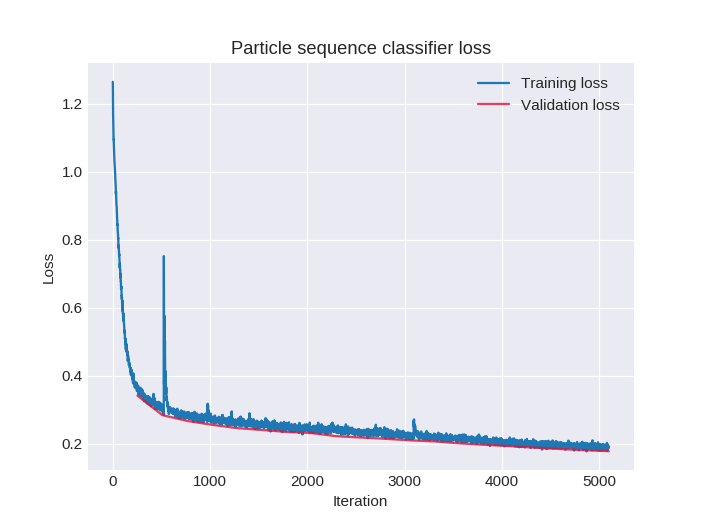

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
loss = np.array(trainSummary.read_scalar("Loss"))
valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("Inclusive classifier loss")
plt.show()

## Save the model

In [23]:
modelDir = logDir + '/models'
model.saveModel(
            modelPath = modelDir + '/' + appName + '.bigdl',
            weightPath = modelDir + '/' + appName + '.bin',
            over_write = True
)

It is possible to load the model in the following way:
```Python
model = Model.loadModel(modelPath=modelPath+'.bigdl', weightPath=modelPath+'.bin')
```

## Prediction

In [24]:
pred = model.predict(testRDD)

In [25]:
y_pred = np.asarray(pred.collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [26]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


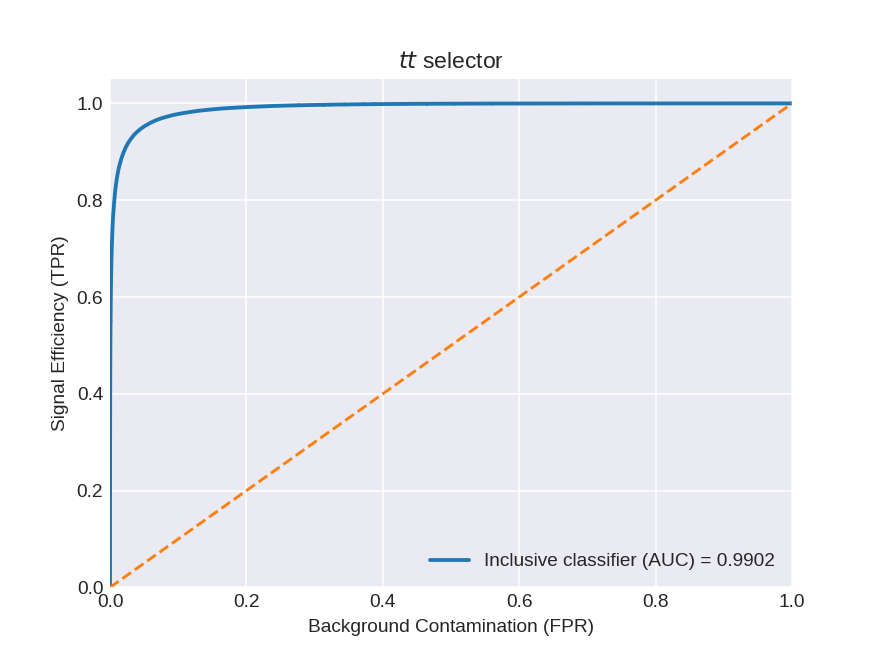

In [27]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='Inclusive classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

In [29]:
from sklearn.metrics import accuracy_score

print('Accuracy of the Inclusive classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the Inclusive classifier: 0.9341


<IPython.core.display.Javascript object>


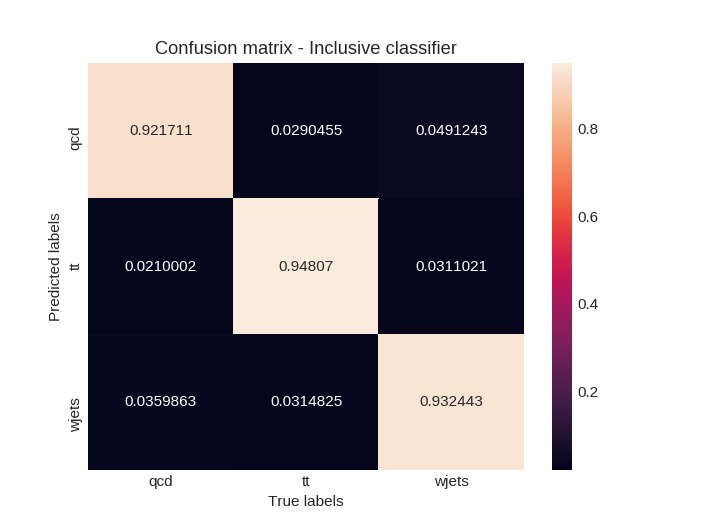

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.title('Confusion matrix - Inclusive classifier')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
spark.stop()